In [11]:
import numpy as np

import math

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (5, 5)
from matplotlib.mlab import griddata

In [23]:
xi = np.linspace(-1.05, 1.05, 100)
yi = np.linspace(-1.05, 1.05, 100)
xx, yy = np.meshgrid(xi, yi)
thetas = np.asarray(list(zip(xx.flatten(), yy.flatten())))

data_dir = '../data'
figure_dir = '../figures'

# Morphing routines

In [24]:
# Morphing
n_samples = 15

def calculate_wtilde(t, component_sample):
    wtilde_components = np.asarray([
        1. + 0. * t[:, 0],
        t[:, 1],
        t[:, 1] * t[:, 1],
        t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 1] * t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 0],
        t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 0],
        t[:, 0] * t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 0],
        t[:, 0] * t[:, 0] * t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 0] * t[:, 0]
    ]).T
    return wtilde_components.dot(component_sample)


def calculate_wi(t, component_sample, sigma_sample, sigma_component):
    wtildes = calculate_wtilde(t, component_sample)
    sigma_wtildes = sigma_sample * wtildes # (?, 15)
    
    denom = np.ones_like(sigma_wtildes.T) # (?, 15)
    denom[:,:] /= np.sum(sigma_wtildes, axis=1)
    denom = denom.T
    
    return (sigma_wtildes * denom).T

# Original morphing

In [25]:
thetas_morphing = np.array([
    [0.,0.],
    [0.,0.25],
    [0.,0.5],
    [0.,0.75],
    [0.,1.],
    [0.25,0.],
    [0.25,0.25],
    [0.25,0.5],
    [0.25,0.75],
    [0.5,0.],
    [0.5,0.25],
    [0.5,0.5],
    [0.75,0.],
    [0.75,0.25],
    [1.,0.]
])

sigma_component = np.load(data_dir + '/morphing/component_xsec.npy')[1:] # Ignore background component
component_sample = np.load(data_dir + '/morphing/component_sample.npy')[1:] # Ignore background component
sigma_sample = np.linalg.inv(component_sample).dot(sigma_component)

wi_original = calculate_wi(thetas, component_sample, sigma_sample, sigma_component)

wi_original = wi_original.reshape(15,100,100)

wi_original_sum = np.sum(wi_original, axis=0)
print(np.min(wi_original_sum), np.max(wi_original_sum))
print(np.var(wi_original))

wi_original = np.clip(wi_original,-1000.,1000.)

0.9999999999995879 1.0000000000003126
12901.216665066362


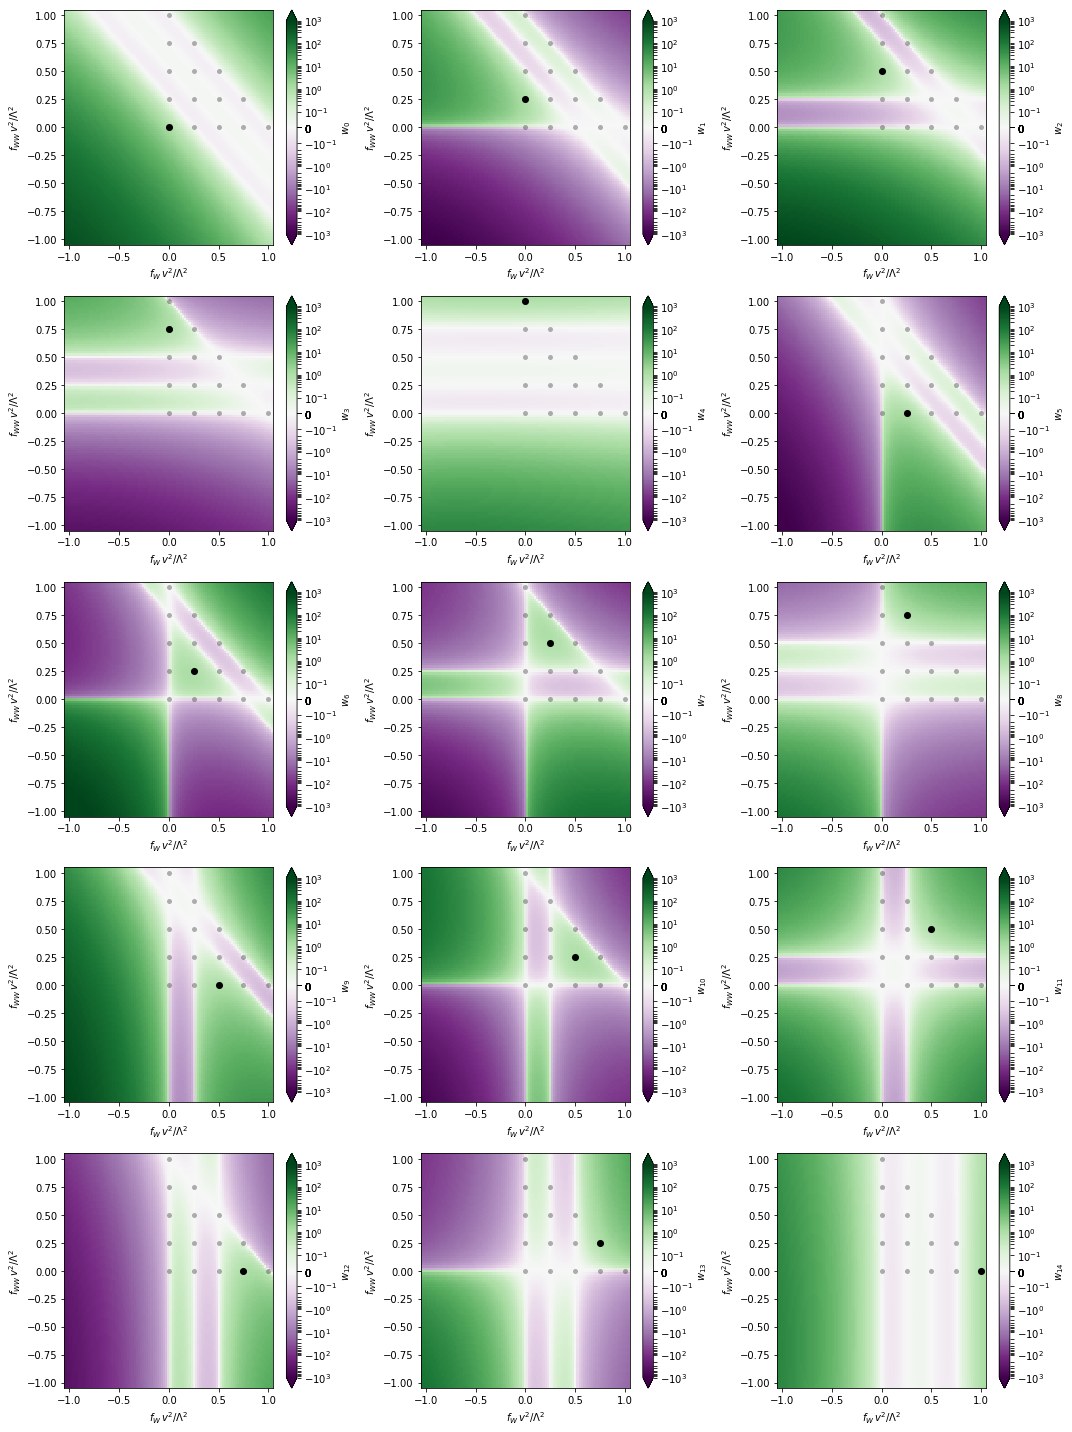

In [26]:
fig = plt.figure(figsize=(15,20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_original[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-1000.0, vmax=1000.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_morphing[:, 0], thetas_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_morphing[i, 0]], [thetas_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing/morphing_original.pdf")

# Fake morphing 1

In [27]:
thetas_fake_morphing = [[0.,0.],
    [-0.8,-0.8],
    [-0.8,0.8],
    [0.8,-0.8],
    [0.8,0.8]]
thetas_fake_morphing += [[0.3*math.cos(-0.1 + n * 2. * math.pi / 3.), 0.3*math.sin(-0.1 + n * 2. * math.pi / 3.)] for n in range(3)]
thetas_fake_morphing += [[0.7*math.cos(0.25 + n * 2. * math.pi / 7.), 0.7*math.sin(0.25 + n * 2. * math.pi / 7.)] for n in range(7)]
thetas_fake_morphing = np.asarray(thetas_fake_morphing)

In [31]:
sample_component = np.load(data_dir + '/morphing/components_fakebasis.npy')[:,1:] # Ignore background component
component_sample = np.linalg.inv(sample_component)
sigma_sample = np.load(data_dir + '/morphing/fakebasis_xsecs.npy')
sigma_component = component_sample.dot(sigma_sample)

wi_fake = calculate_wi(thetas, component_sample, sigma_sample, sigma_component)
wi_fake = wi_fake.reshape(15,100,100)

wi_fake_sum = np.sum(wi_fake, axis=0)
print(np.min(wi_fake_sum), np.max(wi_fake_sum))
print(np.var(wi_fake))

wi_fake = np.clip(wi_fake,-1000.,1000.)

0.9999999999998934 1.0000000000000746
169.00919229621252


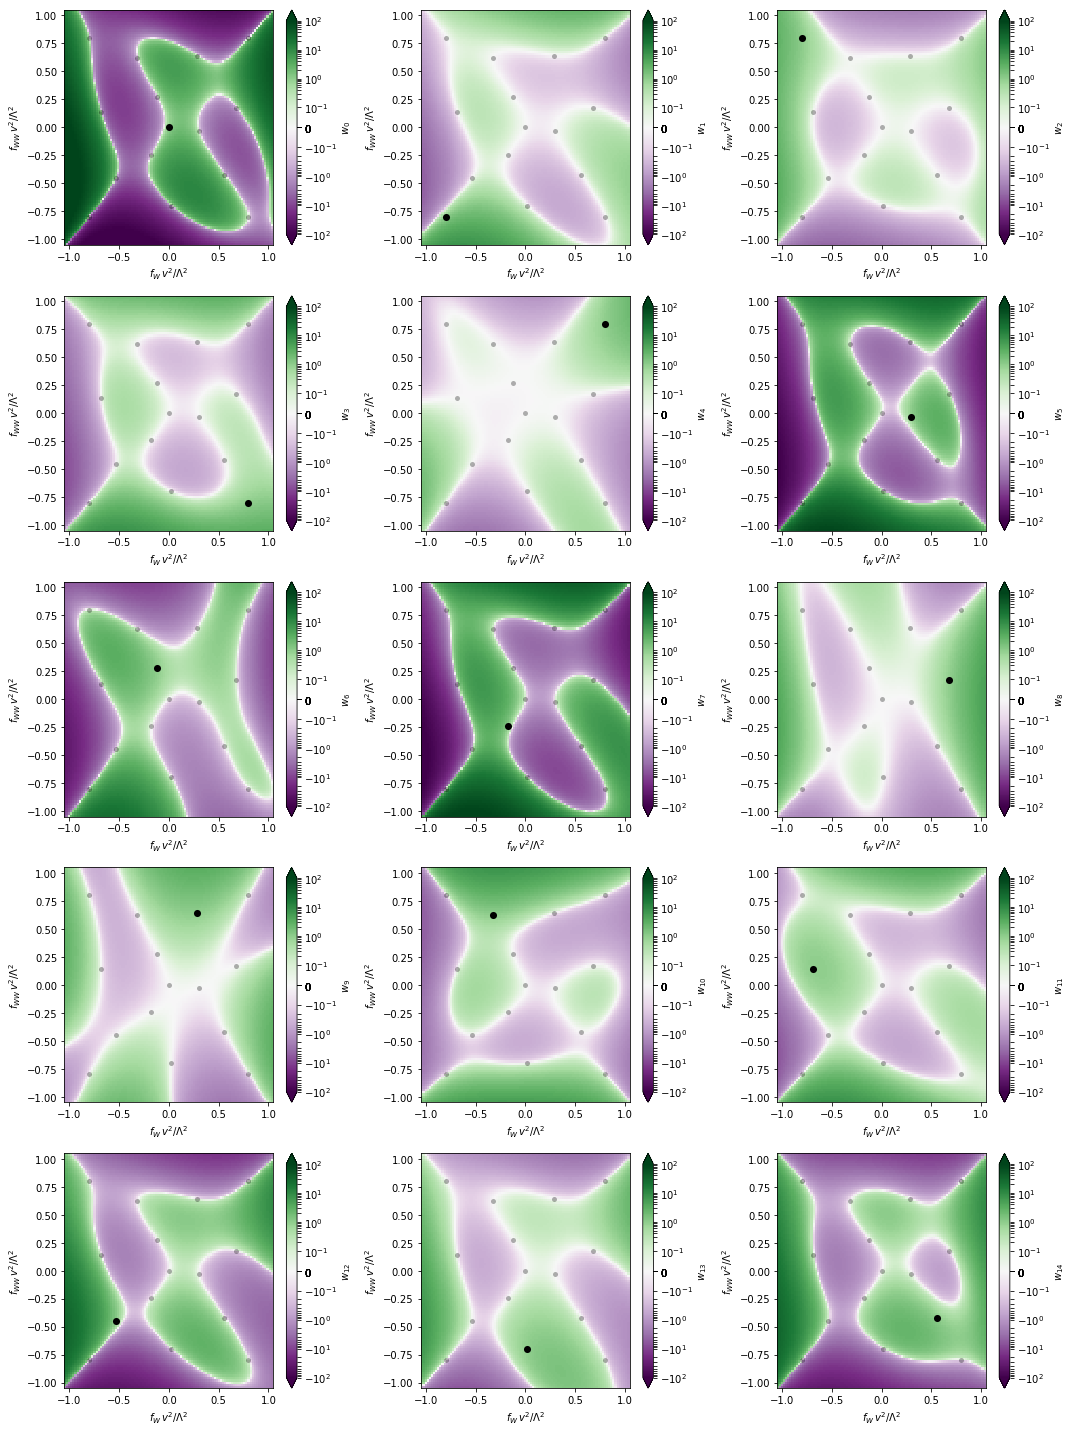

In [32]:
fig = plt.figure(figsize=(15,20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_fake[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                                         vmin=-100.0, vmax=100.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_fake_morphing[:, 0], thetas_fake_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_fake_morphing[i, 0]], [thetas_fake_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_optimized.pdf")

# Fake morphing 2

(-1.1, 1.1)

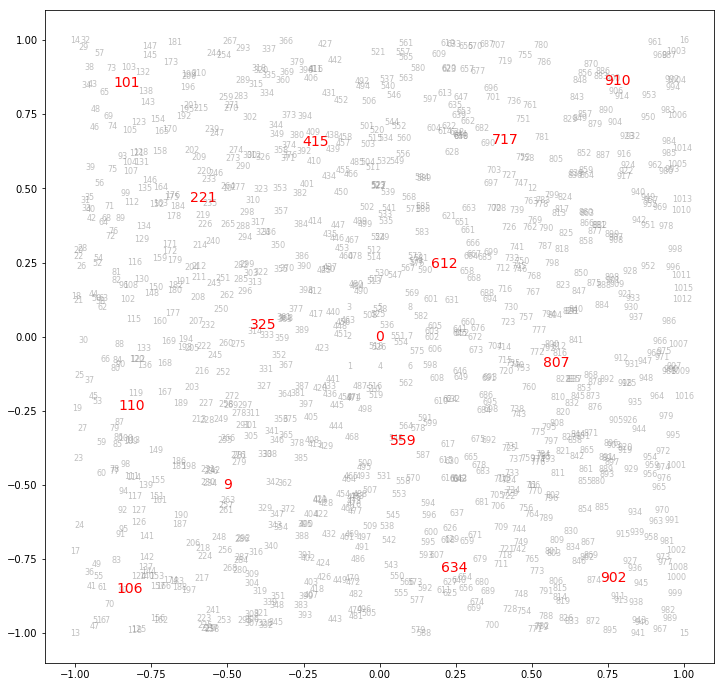

In [45]:
highlighted = [0, 101, 106, 902, 910,
              226, 373, 583, 747, 841,
              599, 709, 422, 367, 167]

plt.figure(figsize=(12,12))

for i, theta in enumerate(np.load(data_dir + '/thetas/thetas_parameterized.npy')):
    plt.text(theta[0],theta[1],str(i),
             fontsize = 14 if i in highlighted else 8,
             alpha = 1. if i in highlighted else 0.5,
             color = 'red' if i in highlighted else 'grey',
             horizontalalignment = 'center',
             verticalalignment = 'center')
    
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

In [53]:
choice = [0, 101, 106, 902, 910,
          226, 373, 583, 747, 841,
          599, 709, 422, 367, 167]

thetas_fake_morphing = np.load(data_dir + '/thetas/thetas_parameterized.npy')[choice]

In [54]:
sample_component = np.load(data_dir + '/morphing/components_fakebasis2.npy')[:,1:] # Ignore background component
component_sample = np.linalg.inv(sample_component)
sigma_sample = np.load(data_dir + '/morphing/fakebasis2_xsecs.npy')
sigma_component = component_sample.dot(sigma_sample)

wi_fake = calculate_wi(thetas, component_sample, sigma_sample, sigma_component)
wi_fake = wi_fake.reshape(15,100,100)

wi_fake_sum = np.sum(wi_fake, axis=0)
print(np.min(wi_fake_sum), np.max(wi_fake_sum))
print(np.var(wi_fake))

wi_fake = np.clip(wi_fake,-1000.,1000.)

0.9999999999999414 1.000000000000051
121.3292922608206


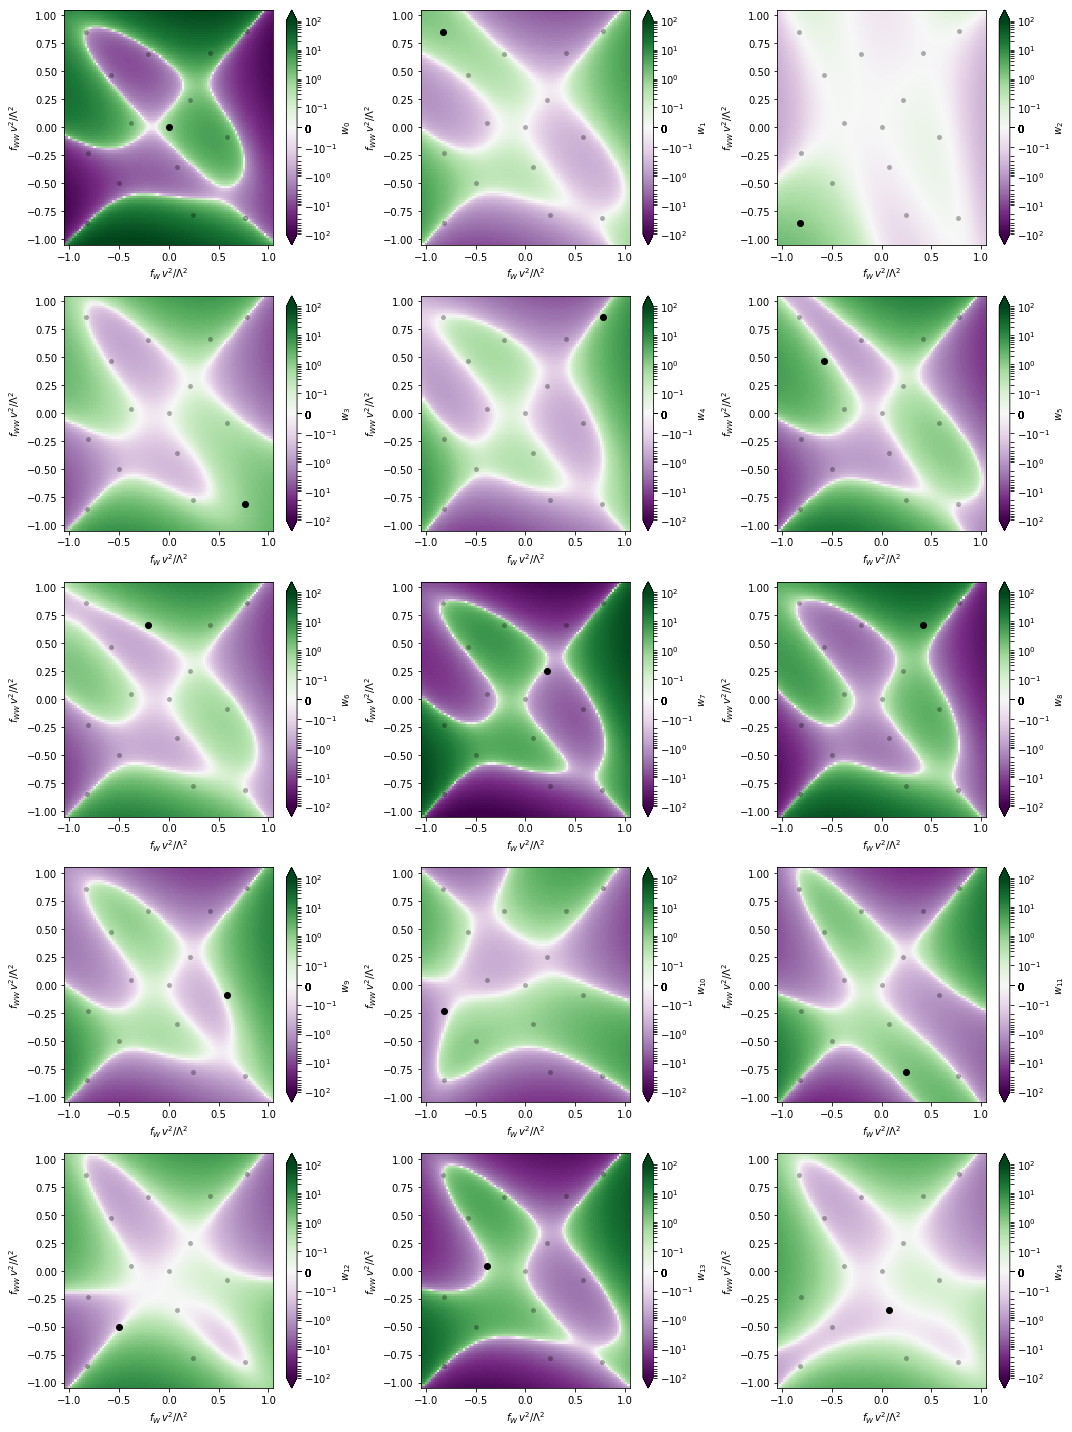

In [48]:
fig = plt.figure(figsize=(15,20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_fake[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-100.0, vmax=100.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_fake_morphing[:, 0], thetas_fake_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_fake_morphing[i, 0]], [thetas_fake_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_optimized2.pdf")

(-1.1, 1.1)

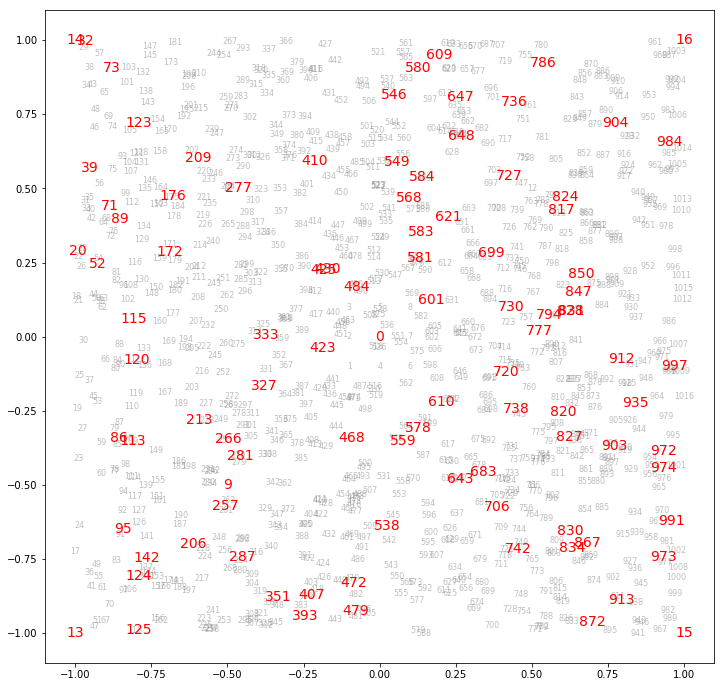

In [61]:
highlighted = [0,13,14,15,16,9,213] + list(np.random.randint(17,1016,93))

plt.figure(figsize=(12,12))

for i, theta in enumerate(np.load(data_dir + '/thetas/thetas_parameterized.npy')):
    plt.text(theta[0],theta[1],str(i),
             fontsize = 14 if i in highlighted else 8,
             alpha = 1. if i in highlighted else 0.5,
             color = 'red' if i in highlighted else 'grey',
             horizontalalignment = 'center',
             verticalalignment = 'center')
    
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

In [62]:
print(highlighted)

[0, 13, 14, 15, 16, 9, 213, 647, 736, 643, 794, 727, 52, 86, 824, 538, 581, 828, 583, 549, 738, 872, 912, 935, 410, 209, 972, 706, 120, 113, 407, 281, 115, 20, 820, 172, 32, 546, 176, 974, 71, 831, 834, 730, 266, 621, 333, 742, 991, 647, 580, 124, 817, 720, 95, 142, 984, 777, 699, 472, 479, 206, 830, 287, 648, 393, 610, 257, 683, 425, 827, 484, 568, 601, 913, 39, 830, 973, 786, 468, 609, 430, 73, 89, 578, 850, 997, 176, 125, 277, 847, 867, 904, 584, 327, 423, 559, 351, 123, 903]
